# This Projects is to classfie Arabic handwritten  characters by using keras framework

## 1. Import Libraries

In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras import regularizers, optimizers

## 2. Import and display data

In [60]:
# read data
x_train = pd.read_csv('Data/ArabicHandwrittenCharactersDatasetCSV/csvTrainImages 13440x1024.csv', header = None)
y_train = pd.read_csv('Data/ArabicHandwrittenCharactersDatasetCSV/csvTrainLabel 13440x1.csv', header = None)
x_test = pd.read_csv('Data/ArabicHandwrittenCharactersDatasetCSV/csvTestImages 3360x1024.csv', header = None)
y_test = pd.read_csv('Data/ArabicHandwrittenCharactersDatasetCSV/csvTestLabel 3360x1.csv', header = None)


In [61]:
x_train = x_train.iloc[:,:].values
y_train = y_train.iloc[:,:].values
x_test = x_test.iloc[:,:].values
y_test = y_test.iloc[:,:].values

In [62]:
x_train =  np.reshape(x_train , (13440 , 32 , 32 , 1))
x_test =  np.reshape(x_test , (3360 , 32 , 32 , 1))

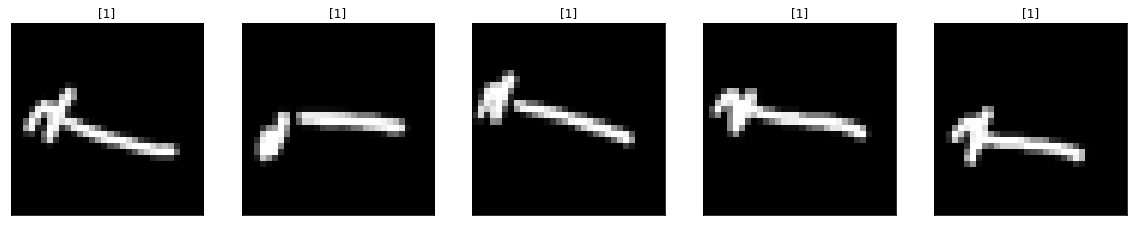

In [63]:
# this code from https://github.com/moelgendy/deep_learning_for_vision_systems
fig = plt.figure(figsize=(20,20))

for i in range(5):
    ax = fig.add_subplot(1,5, i+1, xticks=[], yticks=[])
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(str(y_train[i]))

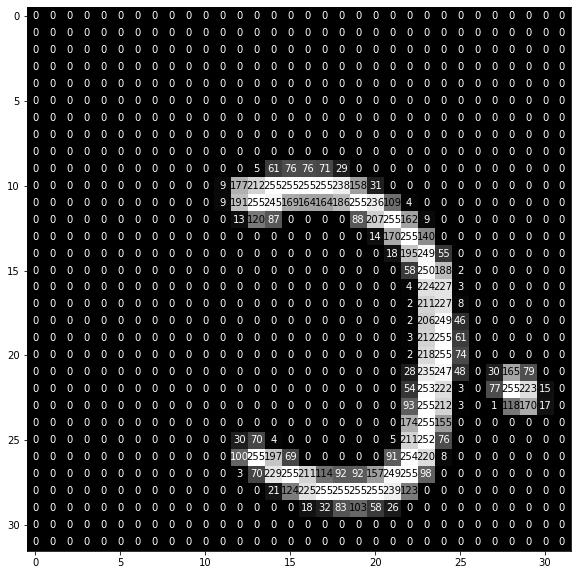

In [64]:
# this code from https://github.com/moelgendy/deep_learning_for_vision_systems
def viz_input(img, ax):
    ax.imshow(img, 'gray')
    width, height = img.shape[:-1]
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(np.round(img[x][y][0],2)), xy=(y,x),
                       horizontalalignment = 'center',
                        verticalalignment = 'center',
                        color = 'white' if img[x][y] < thresh else 'black'
                       )
            
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
viz_input(x_train[10], ax)

# 3.Preproccssing

In [65]:
# Normlize the data
x_train = x_train.astype('float32') /255
x_test = x_test.astype('float32') /255


# there is problem which is the to_categorical expect class start from 0 so we should subtract 1 from classess

y_train = y_train -1
y_test  =  y_test - 1


# on-hot encoding
num_classes  = len(np.unique(y_train) )
y_train = to_categorical(y_train,num_classes )
y_test = to_categorical(y_test, num_classes )

In [75]:
# split data into train and validation
x_train, x_valid = x_train[3000:], x_train[:3000]
y_train, y_valid = y_train[3000:], y_train[:3000]

In [76]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(10440, 32, 32, 1)
(3000, 32, 32, 1)
(3360, 32, 32, 1)


## 4. Model Creation

In [102]:

base_hidden_units = 32
weight_decay = 1e-4


model = Sequential()

# Conv1
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay),
                input_shape= x_train.shape[1:]))
model.add(BatchNormalization())
          
# Conv2         
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
          
# Pool & dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
          
          
          
# Conv3
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
          
# Conv4        
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
          
# Pool & dropout 2
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Conv5
model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
          
# Conv6        
model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
          
# Pool & dropout 2
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
          
          
          
# FC 7        
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

          
# model summray()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)       

## 5. Data augmentation 

In [105]:
# data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )

# compute the data augmentation on the training set
datagen.fit(x_train)

## 6. Train The model

In [106]:
batch_size = 128
epochs=100

checkpointer = ModelCheckpoint(filepath='model.100epochs.hdf5',
                               verbose=1, save_best_only=True)
optimizer = optimizers.Adam(learning_rate=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])


In [107]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                   callbacks=[checkpointer],steps_per_epoch=x_train.shape[0] // batch_size,
                  epochs=epochs,verbose=1, validation_data=(x_valid,y_valid))

Epoch 1/100
81/81 [==============================] - 43s 516ms/step - loss: 6.0371 - accuracy: 0.0416 - val_loss: 3.6902 - val_accuracy: 0.0373

Epoch 00001: val_loss improved from inf to 3.69024, saving model to model.100epochs.hdf5
Epoch 2/100
81/81 [==============================] - 41s 509ms/step - loss: 4.8620 - accuracy: 0.0890 - val_loss: 5.1347 - val_accuracy: 0.0383

Epoch 00002: val_loss did not improve from 3.69024
Epoch 3/100
81/81 [==============================] - 41s 509ms/step - loss: 4.3501 - accuracy: 0.1073 - val_loss: 6.1496 - val_accuracy: 0.0377

Epoch 00003: val_loss did not improve from 3.69024
Epoch 4/100
81/81 [==============================] - 42s 513ms/step - loss: 3.9879 - accuracy: 0.1265 - val_loss: 6.3112 - val_accuracy: 0.0493

Epoch 00004: val_loss did not improve from 3.69024
Epoch 5/100
81/81 [==============================] - 42s 513ms/step - loss: 3.7072 - accuracy: 0.1509 - val_loss: 5.4879 - val_accuracy: 0.0713

Epoch 00005: val_loss did not imp

81/81 [==============================] - 41s 501ms/step - loss: 0.7414 - accuracy: 0.7658 - val_loss: 0.7714 - val_accuracy: 0.7760

Epoch 00039: val_loss did not improve from 0.76301
Epoch 40/100
81/81 [==============================] - 41s 500ms/step - loss: 0.7349 - accuracy: 0.7725 - val_loss: 0.8018 - val_accuracy: 0.7800

Epoch 00040: val_loss did not improve from 0.76301
Epoch 41/100
81/81 [==============================] - 41s 500ms/step - loss: 0.6699 - accuracy: 0.7920 - val_loss: 0.7110 - val_accuracy: 0.8023

Epoch 00041: val_loss improved from 0.76301 to 0.71105, saving model to model.100epochs.hdf5
Epoch 42/100
81/81 [==============================] - 40s 499ms/step - loss: 0.6736 - accuracy: 0.7906 - val_loss: 0.7177 - val_accuracy: 0.8043

Epoch 00042: val_loss did not improve from 0.71105
Epoch 43/100
81/81 [==============================] - 41s 502ms/step - loss: 0.6513 - accuracy: 0.7988 - val_loss: 0.8073 - val_accuracy: 0.7780

Epoch 00043: val_loss did not improve

81/81 [==============================] - 42s 513ms/step - loss: 0.3501 - accuracy: 0.8985 - val_loss: 0.6858 - val_accuracy: 0.8257

Epoch 00078: val_loss did not improve from 0.52735
Epoch 79/100
81/81 [==============================] - 41s 501ms/step - loss: 0.3520 - accuracy: 0.8997 - val_loss: 0.5739 - val_accuracy: 0.8430

Epoch 00079: val_loss did not improve from 0.52735
Epoch 80/100
81/81 [==============================] - 40s 499ms/step - loss: 0.3291 - accuracy: 0.9073 - val_loss: 0.7237 - val_accuracy: 0.8057

Epoch 00080: val_loss did not improve from 0.52735
Epoch 81/100
81/81 [==============================] - 41s 500ms/step - loss: 0.3329 - accuracy: 0.9019 - val_loss: 0.6223 - val_accuracy: 0.8400

Epoch 00081: val_loss did not improve from 0.52735
Epoch 82/100
81/81 [==============================] - 40s 498ms/step - loss: 0.3350 - accuracy: 0.9054 - val_loss: 0.5343 - val_accuracy: 0.8630

Epoch 00082: val_loss did not improve from 0.52735
Epoch 83/100
81/81 [========

# 7. Evaluate the model

In [108]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

27/27 [==============================] - 2s 67ms/step - loss: 0.2215 - accuracy: 0.9524

Test result: 95.238 loss: 0.221


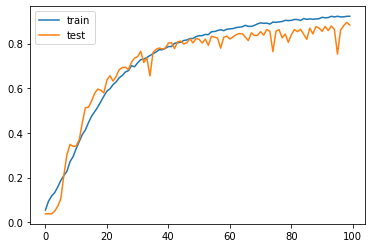

In [109]:
# plot learning curves of model accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

# 9. Predict 

In [111]:
pred = model.predict(x_test)

In [128]:
classes_name = 'أ ب ت ث ج ح خ د ذ ر ز س ش ص ض ط ظ ع غ ف ق ك ل م ن ه و ي'.split()


In [142]:
def disply_img(index):
        # displaying the character  Correct 
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(x_test[index])
    ax1.set_title(f'\nPred: {classes_name[np.argmax(pred[index])]}')
    plt.show()

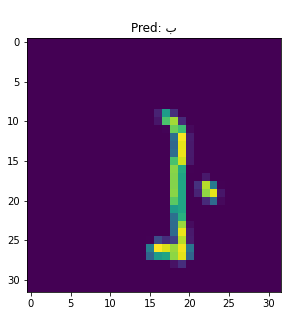

In [144]:
# Correct predction
disply_img(1234)

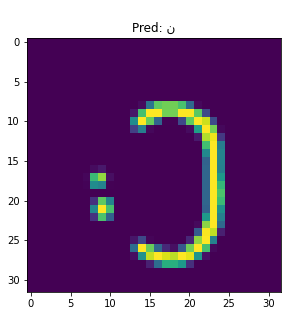

In [146]:
# Wrong predction
disply_img(5)